In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
%matplotlib inline
sns.set_style('darkgrid')
fileName = '000EBA0001-1SD1.csv'

# __READING FWD FILES__
<div style="text-align: justify"> 
Our first task is reading relevant information from a '.FWD' data file. Since this format isn't familiar for
most of us, it's not a good option to choose a Pandas built-in reading function. Instead, I prefer for opening 
this file, seeking for relevant information, and suitably writing this information on a '.csv' file. Unfortunately,
sometimes FWD gives us improperly formated data so that we need to account for error correction when reading a .FWD file; I'll discuss this later on. </div>

## __Getting to know the file structure__
<div style="text-align: justify"> 
This point is extremely crucial. If we want to extract relevant information from a data file, we should know well how
this information is written. </div>

* Date

<div style="text-align: justify"> 
This information is stored in the very first line, from the 11th character to the 18th character.
</div>

* Number of sensors

<div style="text-align: justify"> 
This information is represented by the first character in the second line.
</div>

* Sensors output

<div style="text-align: justify"> 
The outputs from each test station start at the 38th line. Measurements from each station are labelled by the character S so that every pair of lines which follows a line starting by S represents a pair o drops. If the ith line starts by S, for exampe, then in the line i+1 we'll find the sensors-output from the first drop, and in the line i+2, we'll find outputs from the second drop. 
</div>

* Time, distance and temperature

<div style="text-align: justify"> 
The time when a measurement was performed is stored at the last three characters in every line starting by S. If these characters are, for example, '925', it means that the measurement was performed at 09:25 am.

The distance from the first test station is codified on the first character block after the character 'S'. If a block contains the string '0.120NA', for example, this means that this station was 120m away from the first test station. 

Furthermore, we can find either the pavement surface temperature and the air temperature in every line starting by S. The air temperature is represented by a 2-digit number in the third character-block, and the pavement surface temperature is in the fourth character-block as a 2-digit number as well.

For sumarizing consider the following line: _S   0.150NA          37 25 30922_. This means that the measurement was performed at 09:22am, 150m away from the first station, when air temperature was 25 °C and pavement surface temperature was 37°C.
</div>

* Pressure and deflections

<div style="text-align: justify"> 
This information from the first and second drop is stored in the lines i+1 and i+2, respectively. The first block in these lines stands for the pressure, and the other blocks stand for deflections measured by the sensors $D_0$, $D_{20}$, $D_{30}$, etc. For example, consider the following line:

<i><center>804 799 387 269 148 109  64  46</center></i>

According to this line we have: Pressure = 804 MPa, $D_0$= 799 $\mu m$, $D_{20}$= 387 $\mu m$, $D_{30}$= 269 $\mu m$, $D_{45}$= 148 $\mu m$, $D_{65}$= 109 $\mu m$, $D_{90}$= 64 $\mu m$, and $D_{120}$= 46 $\mu m$.
</div>

## __Accounting for possible errors__

<div style="text-align: justify"> 
As mentioned before, measurement results from each station are written line by line and separated by blank spaces. Unfortunately, due to something unknown, sometimes it not occur. More often then we'd appreciate, information comes bonded in a single character block such that we'd not have, in a single line, eight blocks of character as exemplified early. For clarificatoin, have a look at the following line:

<i><center>129522461140 641 305 176  89  64</center></i>

This line contains only six blocks of character, so how could we properly extract information form this? To overcome that we must know well how FWD works and what may and what may not occur in a test section. Essentially, we have to check whether a line contains eight blocks of character - otherwise, we need to handle the information so that we can get exactly what we want. For a piece of more detailed information on how to do that, you might have a look at the file <i>errorHandling.txt</i>. </div>

## __File and string manipulation__
<div style="text-align: justify"> 
In the following block, there's quite a bit of file and string manipulation. This step is necessary for us either to deal with undesirable situations - like the one mentioned before - and to adjust the data to a more convenient formating. The good news is that since we've done this once, there's no need to manipulate the file again because the data will be stored in a suitable format and won't consume our time again. </div>

In [4]:
if fileName.split('.')[1]=='FWD':
    i=0
    with open(fileName, 'r') as inFile, \
         open(fileName.split('.')[0]+'.csv', 'w') as outFile:
            content=inFile.read()
            date=content.splitlines()[0][11:19]
            date=date[-2:]+'-'+date[-4:-2]+'-'+date[0:4]
            numOfDef=int(content.splitlines()[1][0])
            outFile.write('X,P,D0,D20,D30,D45,D65,D90,D120,Ts,Ta,Date,Hour,Minutes\n')
            measures = content.splitlines()[37:]
            while i<len(measures):
                if measures[i][0]=='S':
                    hora = (measures[i][-4:-2])
                    minutos = (measures[i][-2:])
                    #CHECK IF THERE'S GROUPED VALUES
                    if len(measures[i+1].split())==8:
                        measures[i+1] = ' '.join(measures[i+1].split())
                    else:
                        dif = 8 - len(measures[i+1].split())
                        if int(measures[i+1].split()[0][0])==1:
                            k=0
                            hold = []
                            while k<=dif:
                                hold.append(measures[i+1].split()[0][k*4:(k+1)*4].lstrip())    
                                k+=1
                            measures[i+1]=' '.join(hold+measures[i+1].split()[1:])
                        else:
                            measures[i+1] = [measures[i+1].split()[0][:3]]+[measures[i+1].split()[0][3:7]]+[measures[i+1].split()[0][7:]]+measures[i+1].split()[1:]
                            while ("" in measures[i+1]):
                                measures[i+1].remove("")
                            measures[i+1] = ' '.join(measures[i+1])
                            
                    if len(measures[i+2].split())==8:
                        measures[i+2] = ' '.join(measures[i+2].split())
                    else:
                        dif=8 - len(measures[i+2].split())
                        if int(measures[i+2].split()[0][0])==1:
                            k=0
                            hold=[]
                            while k<=dif:
                                hold.append(measures[i+2].split()[0][k*4:(k+1)*4].lstrip())
                                k+=1
                            measures[i+2] = ' '.join(hold+measures[i+2].split()[1:])
                        else:
                            measures[i+2] = [measures[i+2].split()[0][:3]]+[measures[i+2].split()[0][3:7]]+[measures[i+2].split()[0][7:]]+measures[i+2].split()[1:]
                            while ("" in measures[i+2]):
                                measures[i+2].remove("")
                            measures[i+2] = ' '.join(measures[i+2])
                    outFile.write(measures[i][1:].lstrip()[:5]+','+measures[i+1].split(' ')[0]+','+measures[i+1].split(' ')[1]+','+measures[i+1].split(' ')[2]+','\
                                  +measures[i+1].split(' ')[3]+','+measures[i+1].split(' ')[4]+','+measures[i+1].split(' ')[5]+','+measures[i+1].split(' ')[6]+','+measures[i+1].split(' ')[7]+','\
                                  +' '.join(measures[i].split()).split(' ')[2]+','+' '.join(measures[i].split()).split(' ')[3]+','+date+','+hora+','+minutos+'\n')
                    outFile.write(measures[i][1:].lstrip()[:5]+','+measures[i+2].split(' ')[0][:4]+','+measures[i+2].split(' ')[1]+','+measures[i+2].split(' ')[2]+','\
                                  +measures[i+2].split(' ')[3]+','+measures[i+2].split(' ')[4]+','+measures[i+2].split(' ')[5]+','+measures[i+2].split(' ')[6]+','+measures[i+2].split(' ')[7]+','\
                                  +' '.join(measures[i].split()).split(' ')[2]+','+' '.join(measures[i].split()).split(' ')[3]+','+date+','+hora+','+minutos+'\n')
                i+=3
    myData = pd.read_csv(fileName.split('.')[0]+'.csv')
else:
    myData = pd.read_csv(fileName)

dList= ['D0','D20','D30','D45','D65','D90','D120']
distancia='10'
for i in dList:
    myData[str(i)]=myData[str(i)].apply(lambda x: x/10.)
#LET'S HAVE A LOOK HOW OUR DATA LOOKS LIKE
myData.head()

,X,P,D0,D20,D30,D45,D65,D90,D120,Ts,Ta,Date,Hour,Minutes
0,0.00,804,79.9,38.7,26.9,14.8,10.9,6.4,4.6,37,25,04-09-2019,9,22
1,0.00,1233,110.1,54.2,38.7,22.9,16.4,9.5,6.2,37,25,04-09-2019,9,22
2,0.02,715,161.5,76.2,39.3,19.3,11.9,6.3,4.5,38,25,04-09-2019,9,25
3,0.02,1295,224.6,114.0,64.1,30.5,17.6,8.9,6.4,38,25,04-09-2019,9,25
4,0.04,675,192.9,94.5,48.1,23.8,15.3,7.9,4.1,41,25,04-09-2019,9,28


## __Header information__

<div style="text-align: justify"> 
Now, we manipulate the columns "Date", "Hour", and "Minutes" to get information for the project header. The information we need here is: the day when the test was performed (DD/MM/YYYY), the time when it started, how long it took for surveying the section (in minutes), and how far from the start station the device had gone. </div>

In [5]:
dataInicio=myData['Date'][0]
horaInicio=str(myData['Hour'][0])+':'+str(myData['Minutes'][0])
duracao=60*(myData['Hour'].values[-1]-myData['Hour'][0]) + myData['Minutes'].values[-1]-myData['Minutes'][0]
distancia='%.3f Km'%myData['X'].max()
dic = {'data':dataInicio, 'hora':horaInicio, 'duracao':duracao, 'dist':distancia}
print(' Date = {data}\n Started at= {hora}\n Duration= {duracao} min\n Distance= {dist}'.format(**dic))

 Date = 04-09-2019
 Started at= 9:22
 Duration= 120 min
 Distance= 1.217 Km


## __Sensors deflection__
<div style="text-align: justify">
    Let's have a first look at how our sensors have performed. This part is important so that we can seek either for possible failures in the sensors, by analyzing if every single sensor follows the same global trend, and for sections where further structural analysis is needed. </div>

Text(0, 0.5, 'Maximum deflection ($mm \\times 10^{-2}$)')

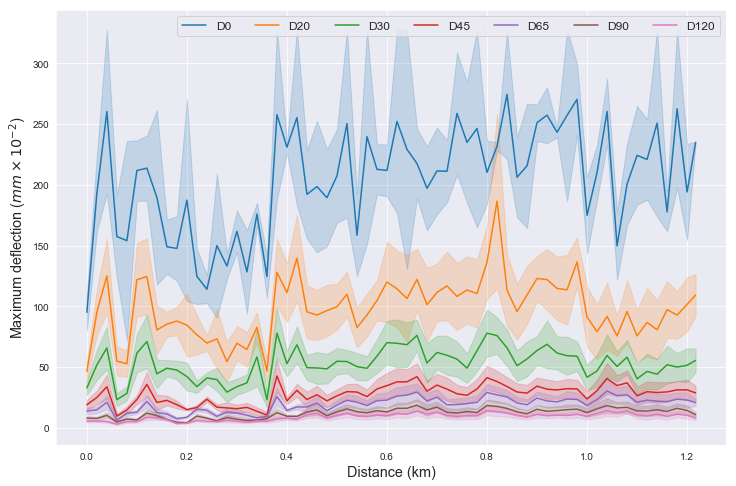

In [27]:
fig1, ax1 = plt.subplots(1,1, figsize=(12,8))
for i in myData.columns[2:9]:
    sns.lineplot(x='X',y=str(i),data=myData, ax=ax1, label=i)
#sns.set(font_scale=1.0)

ax1.legend(frameon=True, loc='upper right',ncol=len(dList),fontsize='large')
ax1.set_xlabel('Distance (km)',size='x-large')
ax1.set_ylabel(r'Maximum deflection ($mm \times 10^{-2}$)',size='x-large')

##  Determination of homogeneous sub-sections

It seems that there's a trend followed by every single sensor to output higher average deflection for x greater than a value of about 0.37. Let's have a closer look by applying a moving average filter on the data from the two first sensors. 

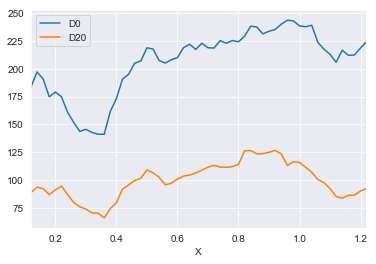

In [8]:
mavgDf = myData[['X','D0','D20']].groupby('X').mean().rolling(window=7).mean().dropna()
mavgDf.plot()

From the image above, it is appearent that there are four segments of approximately homogeneous values: $0.0<x<0.2$, $0.2<x<0.4$, $0.4<x<1.0$, and $x>1.0$.

By applying a simple (but very effective) statistical procedure, we can discriminate homogeneous sub-sections within a larger section. A homogeneous sub-section is defined as a section where the deflections, and so the flexural stiffness, are more or less constant. These can be determined by means of the method of the cumulative sums. First of all the mean deflection over the entire section is calculated. Next, these differences are summed up and plotted. The inflection points typically represent changes in sub-section.


In [23]:
difDF = mavgDf - mavgDf.mean()

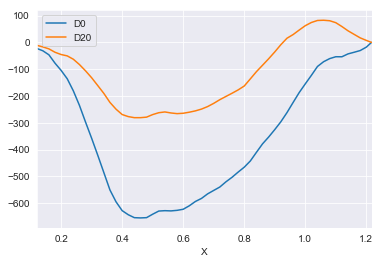

In [26]:
difDF.cumsum().plot()

As we can see, the above figure confirms our last hypothesis that suggested this section has four nearly homogeneous sections.

## __Normalized area ratio parameter__

<div style="text-align: justify">
The normalized area ratio parameter $A'_r$ gives us great indication about the pavement structural condition. Furthermore, this parameter is correlated with the maximum central deflection and with the tensile strain at the bottom of the surface layer -extremely important variables for pavement designers. This parameter is computed according to the following expression:
    <center> $ A'_r = \frac{1}{33D^2_0}[4D_0 +6(D_{20}+D_{120}) +5D_{30} +7D_{45}+9D_{65} +11D_{90}]$ </center>

</div>

In [29]:
def normAreaRatio(arr):
    a = (1/(33.*arr[0]**2))
    return ((4*arr[0]+6*(arr[1]+arr[6])+5*arr[2]+7*arr[3]+9*arr[4]+11*arr[5])*a)

In [30]:
calcAr = myData[['D0','D20','D30','D45','D65','D90','D120']]
arArr = []
for i in myData.index:
    arArr.append(normAreaRatio(calcAr.loc[i].values))
myData['Ar'] = pd.Series(arArr)
myData.head()

,X,P,D0,D20,D30,D45,D65,D90,D120,Ts,Ta,Date,Hour,Minutes,Ar
0,0.00,804,79.9,38.7,26.9,14.8,10.9,6.4,4.6,37,25,04-09-2019,9,22,0.004680
1,0.00,1233,110.1,54.2,38.7,22.9,16.4,9.5,6.2,37,25,04-09-2019,9,22,0.003522
2,0.02,715,161.5,76.2,39.3,19.3,11.9,6.3,4.5,38,25,04-09-2019,9,25,0.001903
3,0.02,1295,224.6,114.0,64.1,30.5,17.6,8.9,6.4,38,25,04-09-2019,9,25,0.001448
4,0.04,675,192.9,94.5,48.1,23.8,15.3,7.9,4.1,41,25,04-09-2019,9,28,0.001625


## __Correlations__
Let's seek for correlations between two or more variables involved in our study. To do so, I'll represent the correlation matrix as a seaborn heatmap.

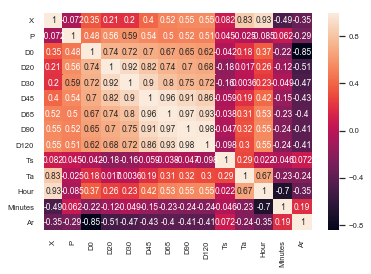

In [31]:
sns.set(font_scale=0.7)
sns.heatmap(myData.corr(),annot=True)

As we can see from the heatmap above, there's a positive correlation between the variables X and Hour. This is quite obivious since as our device get farther from the start point the time keep going on. It's also possible to note that there's positive correlations between the sensors positioned farther away from the load, for example $D_{90}$ and $D_{120}$. What I'd like to point ou here is the negative correlation between $A'_r$ and $D_0$, which means that when one variable increases the other decreases. It's time to have a closer look at what goes on with $A'_r$ and $D_0$ and see if we can establish a mathematical relation between them.

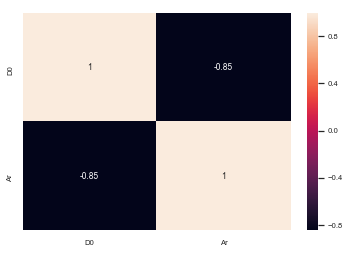

In [32]:
sns.heatmap(myData[['D0','Ar']].corr(), annot=True)

Text(0, 0.5, 'D0 ($\\mu m$)')

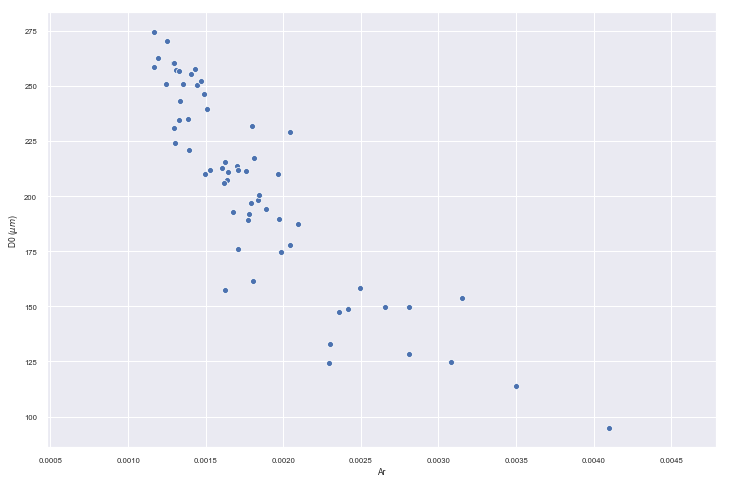

In [33]:
fig2, ax2 = plt.subplots(1,1,figsize=(12,8))
grouped_by_x_data = myData.groupby('X').mean()
sns.scatterplot(x='Ar',y='D0',data=grouped_by_x_data,ax=ax2, marker='o')
ax2.set_ylabel('D0 ($\mu m$)')

It seems that there's a power law between these two variables. I'll try to fit a function like:
<center> $D_0 = A\times A_r^{'-\beta}$</center>

In [34]:
def model1(Ar,A,B):
    return A*Ar**-B

popt, pcov = curve_fit(model1, xdata=grouped_by_x_data['Ar'].values, ydata=grouped_by_x_data['D0'].values)
deviat1 = (np.sqrt(np.diag(pcov))[0]/popt[0])*100
deviat2 = (np.sqrt(np.diag(pcov))[1]/popt[1])*100

Now we calculate the percentual deviations of the parameters $A$ and $\beta$ to see how our fit performed.

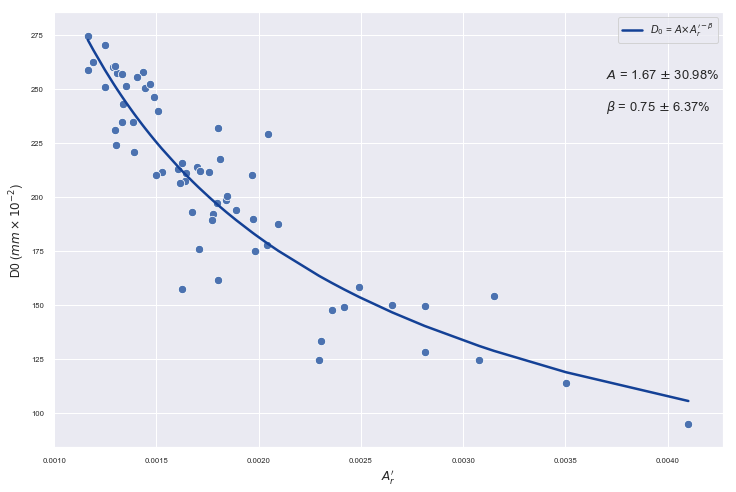

In [40]:
fig3, ax3 = plt.subplots(1,1,figsize=(12,8))
sns.lineplot(x=grouped_by_x_data['Ar'].values, y=model1(grouped_by_x_data['Ar'].values, *popt), ax=ax3, linewidth=2.5, color='#144196',
            label=r'$D_0$ = $A$$\times A_r^{\prime-\beta}$' )
sns.scatterplot(x='Ar',y='D0',data=grouped_by_x_data,ax=ax3, s=70)
plt.text(x=0.0037,y=255,s=r'$A$ = %.2f $\pm$ %.2f%%' % (popt[0],deviat1), fontsize=13 )
plt.text(x=0.0037,y=240,s=r'$\beta$ = %.2f $\pm$ %.2f%%' % (popt[1],deviat2), fontsize=13 )

ax3.set_ylabel(r'D0 ($mm\times 10^{-2}$)', size='x-large')
ax3.set_xlabel(r'$A^{\prime}_r$', size='x-large')
ax3.legend(loc='upper right', frameon=True, fontsize='large')

Fair enough, right?! So we've determined a mathematical relation between two variables collected by field tests. This will help the engineers to determine, for this section, the pavement residual life and will give them guidelines for designing asphalt overlay.